# Student Alcohol Consumption

Martin Škára + Jindřich Buk

Tato semestrální práce se zabývá zpracováním datasetu Student Alcohol Consumption, získaného zde: https://data.world/data-society/student-alcohol-consumption. Tento iPython notebook se skládá z následujících částí: základní popis tohoto datasetu, zpracování a preprocessing dat, vizualizace dat, vytvoření modelů, tuning metaparametrů, výsledky a evaluace. 


## Popis datasetu

Data byla získána pomocí dotazníku mezi studenty matematiky a portugalštiny na střední škole. Samotný dataset je rozdělený mezi dva menší - jeden obsahuje odpovědi studentů matematiky, druhý odpovědi studentů portugalštiny. Dataset samotný se zajímá různými informacemi o studentovi, ale jeho cílem je zmapovat chování a zázemí studentů a jejich vztah k alkoholu.

### Atributy datasetu

* *school* - Škola, na kterou studenti chodí ('GP' - Gabriel Pereira a 'MS' - Mousinho da Silveira)
* *sex* - Pohlaví studenta ('F' pro ženu, 'M' pro muže)
* *age* - Věk studenta (číslo)
* *adress* - Typ studentova bydliště ('U' - urban (město), 'R' - rural (venkov))
* *famsize* - Počet členů studentovy rodiny v domácnosti ('LT3' - 3 a méně, 'GT3' - více než 3)
* *Pstatus* - Atribut označuje zdali studentovi rodiče žijí spolu či ne ('T' - žijí spolu, 'A' - žijí odděleně)
* *Medu* - vzdělání matky (0 - žádné, 1 - základní vzdělání (4th grade), 2 - základní vzdělání (více než 4th grade), 3 - středoškolské vzdělání, 4 - vyšší vzdělání)
* *Fedu* - obdobný atribut jako Medu, označující vzdělání otce
* *Mjob* - práce matky ('teacher' - učitelka, 'health' - vztahující se ke zdraví a péči, 'services' - státní zaměstnankyně, 'at_home' - v domácnosti, 'other' - jiné)
* *Fjob* - obdobný atribut jako Mjob, označující práci otce
* *reason* - Důvod, proč si student vybral jeho školu ('home' - blízko domova, 'reputation' - reputace školy, 'course' - kvůli předmětům/oboru, 'other' - jiné)
* *guardian* - zákonný zástupce ('mother' - matka, 'father' - otec, 'other' - někdo jiný)
* *traveltime* - jak dlouho student cestuje do školy (1 - do 15 min., 2 - mezi 15 a 30 min., 3 - mezi 30 min. a 1 hodinou, 4 - více než hodinu)
* *studytime* - kolik hodin týdně se student doma učí (1 - méně než 2 hodiny, 2 - 2-5 hodin, 3 - 5-10 hodin, 4 - více než 10 hodin)
* *failures* - kolik předmětů student dokončil neúspěšně
* *schoolsup* - Má extra doučování ve škole
* *famsup* - Má doučování doma od rodiny
* *paid* - Má placené doučování? 
* *activities* - Zdali se student účastní nějakých extra aktivit ve škole (spolky, týmy apod.)
* *nursery* - Chodil student do školky?
* *higher* - Chce jít student dále na vysokou či vyšší odbornou školu?
* *internet* - Má doma student přístup k internetu?
* *romantic* - Má student přítele/přítelkyni?
* *famrel* - Kvalita studentových vztahů v rodině (1 - nejhorší až 5 - nejlepší)
* *freetime* - Kolik volného času má student mimo školu (1 - velmi málo až 5 - velmi mnoho)
* *goout* - Jak často chodí student ven s kamarády (1 - vůbec či téměř ne až 5 - velmi často)
* *Dalc* - Jak moc student konzumuje alkohol v pracovním týdnu (1 - vůbec či téměř ne až 5 - velmi)
* *Walc* - Obdobný atribut jako Dalc, ale označuje konzumaci alkoholu o víkendech
* *health* - studentova zdravotní kondice (1 - velmi špatná až 5 - velmi dobrá)
* *absences* - počet absencí ve škole
* *G1* - známka z předmětu  v prvním pololetí
* *G2* - známka z předmětu  v druhém pololetí
* *G3* - konečná známka z předmětu

Někteří studenti spadají do obou částí datasetu, tj. studovali jak portugalštinu, tak matiku. 

## Zpracování a preprocessing dat

Jelikož, jak bylo psáno v předchozí části tohoto notebooku, se dataset skládá ze dvou menších, je zapotřebí nejdříve tyto dva datasety spojit do jednoho DataFramu. 

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
# import pandas and InteractiveShell
import pandas as pd

# nahrání obou částí datasetu a spojení jich v jeden 
df_1 = pd.read_csv("student-mat.csv")
df_2 = pd.read_csv("student-por.csv")
df = pd.concat([df_1, df_2], ignore_index=True)


Jak lze vidět, vytvořili jsme jeden velký DataFrame. Jenže jak z popisu dat víme, někteří studenti jsou v něm dvakrát, jelikož studovali oba kurzy (Matiku i Portugalštinu). Je třeba tyto duplikáty odstranit. Na stránce, kde jsme dataset získali je zobrazeno, dle kterých atributů lze poznat stejného studenta. 

In [3]:
# odstranění duplikátů z datasetu a resetování indexů řádků
df = df.drop_duplicates(subset=["school", "sex", "age", "address", "famsize", "Pstatus", "Medu", "Fedu", "Mjob", "Fjob", "reason", "nursery", "internet"])
df = df.reset_index(drop=True)


Duplikáty byly odstraněny. Dále smažeme některé sloupce, dle kterých nechceme klasifikovat studentský alkoholismus. Těmi budou school, G1 a G2 (ze známek ponecháme pouze finální známku z předmětu). 

In [4]:
# odstranění některých sloupců
df = df.drop("school", 1)
df = df.drop("G1", 1)
df = df.drop("G2", 1)

Klasifikovat budeme u studentů jejich alkoholismus, tj. výsledným atributem by mohl být Dalc či Walc. Pro zjednodušení tyto dva atributy zprůměrujeme a zaokhoruhlíme nahoru a tak dostaneme společný atribut jak pro pití v pracovním týdnu, tak o víkendu. Zároveň tak můžeme vypustit atributy Dalc a Walc.

In [5]:
# Vytvoření atributu celkového alkoholismu
df["Alc"] = round((df["Dalc"] + df["Walc"])/2)
df["Alc"] = df["Alc"].astype(int)
df = df.drop("Dalc", 1)
df = df.drop("Walc", 1)

Dále upravíme atributy Medu a Fedu, chceme spojit hodnoty 1 a 2, nebudeme rozlišovat stupně základního vzdělání, zajímá nás pouze jestli má rodič základní vzdělání či střední, žádné nebo vyšší.

Nově tak budou tyto atributy nabývat následujících hodnot:

* *0* - žádné vzdělání
* *1* - základní vzdělání
* *2* - středoškolské vzdělání
* *3* - vyšší vzdělání než středoškolské

In [6]:
df["Medu"] = df["Medu"].apply(lambda x: (x if x<2 else x-1))
df["Fedu"] = df["Fedu"].apply(lambda x: (x if x<2 else x-1))
df

,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,...,higher,internet,romantic,famrel,freetime,goout,health,absences,G3,Alc
0,F,18,U,GT3,A,3,3,at_home,teacher,course,...,yes,no,no,4,3,4,3,6,6,1
1,F,17,U,GT3,T,1,1,at_home,other,course,...,yes,yes,no,5,3,3,3,4,6,1
2,F,15,U,LE3,T,1,1,at_home,other,other,...,yes,yes,no,4,3,2,3,10,10,2
3,F,15,U,GT3,T,3,1,health,services,home,...,yes,yes,yes,3,2,2,5,2,15,1
4,F,16,U,GT3,T,2,2,other,other,home,...,yes,no,no,4,3,2,5,4,10,2
5,M,16,U,LE3,T,3,2,services,other,reputation,...,yes,yes,no,5,4,2,5,10,15,2
6,M,16,U,LE3,T,1,1,other,other,home,...,yes,yes,no,4,4,4,3,0,11,1
7,F,17,U,GT3,A,3,3,other,teacher,home,...,yes,no,no,4,1,4,1,6,6,1
8,M,15,U,LE3,A,2,1,services,other,home,...,yes,yes,no,4,2,2,1,0,19,1
9,M,15,U,GT3,T,2,3,other,other,home,...,yes,yes,no,5,5,1,5,0,15,1


Pro potřeby modelů je pak potřeba převést některé kategoriální atributy na numerické.

In [7]:
df["sex"] = pd.factorize(df["sex"])[0]
df["address"] = pd.factorize(df["address"])[0]
df["famsize"] = pd.factorize(df["famsize"])[0]
df["Pstatus"] = pd.factorize(df["Pstatus"])[0]
df["Mjob"] = pd.factorize(df["Mjob"])[0]
df["Fjob"] = pd.factorize(df["Fjob"])[0]
df["reason"] = pd.factorize(df["reason"])[0]
df["higher"] = pd.factorize(df["higher"])[0]
df["internet"] = pd.factorize(df["internet"])[0]
df["romantic"] = pd.factorize(df["romantic"])[0]
df["guardian"] = pd.factorize(df["guardian"])[0]
df["nursery"] = pd.factorize(df["nursery"])[0]
df["schoolsup"] = pd.factorize(df["schoolsup"])[0]
df["famsup"] = pd.factorize(df["famsup"])[0]
df["paid"] = pd.factorize(df["paid"])[0]
df["activities"] = pd.factorize(df["activities"])[0]

## Vizualizace dat

V následující části si pro lepší zorientování v datasetu vizuálně zobrazíme některé atributy a jejich vztah ke konzumaci alkoholu.

(array([250., 288.,  53.,  56.,  15.]),
 array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5]),
 <a list of 5 Patch objects>)

Text(0.5, 0, 'Množství alkoholu')

Text(0, 0.5, 'Počet studentů')

Text(0.5, 1.0, 'Přehled vypitého alkoholu')

([<matplotlib.axis.XTick at 0x2434f30a400>,
 <a list of 6 Text xticklabel objects>)

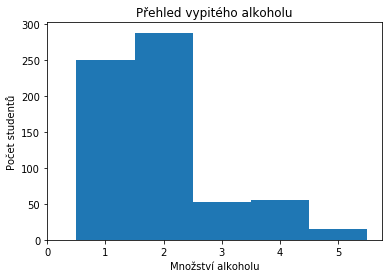

In [8]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

bins = np.arange(0.5,6,1)
plt.hist(df['Alc'],bins=bins)
plt.xlabel('Množství alkoholu')
plt.ylabel("Počet studentů")
plt.title('Přehled vypitého alkoholu')
plt.xticks(range(6))
plt.show()

(array([112., 173., 178., 142.,  45.,   8.,   3.,   1.]),
 array([14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5, 22.5]),
 <a list of 8 Patch objects>)

Text(0.5, 0, 'Věk')

Text(0, 0.5, 'Počet studentů')

Text(0.5, 1.0, 'Věkové rozložení')

([<matplotlib.axis.XTick at 0x2434f3a5b70>,
 <a list of 8 Text xticklabel objects>)

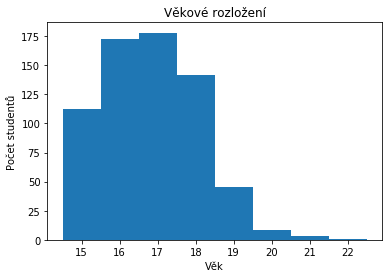

In [9]:
bins = np.arange(14.5,23,1)
plt.hist(df['age'],bins=bins)
plt.xlabel('Věk')
plt.ylabel("Počet studentů")
plt.title('Věkové rozložení')
plt.xticks(range(15,23))
plt.show()

<BarContainer object of 2 artists>

Text(0.5, 0, 'Pohlaví')

Text(0, 0.5, 'Počet studentů')

Text(0.5, 1.0, 'Genderové rozložení')

([<matplotlib.axis.XTick at 0x2434f42c668>,
 <a list of 2 Text xticklabel objects>)

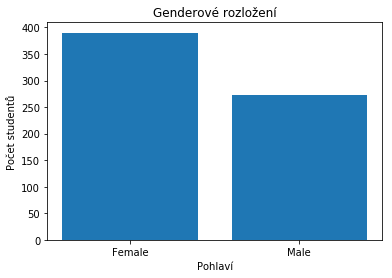

In [10]:
plt.bar([0,1],df['sex'].value_counts())
plt.xlabel('Pohlaví')
plt.ylabel("Počet studentů")
plt.title('Genderové rozložení')
plt.xticks([0,1],['Female','Male'])
plt.show()


Text(0.5, 1.0, 'Závislost věku na vypitém množství alkoholu')

Text(0, 0.5, 'Množství alkoholu')

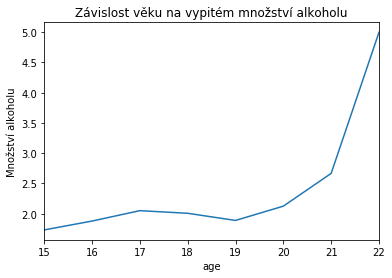

In [11]:
plt.title('Závislost věku na vypitém množství alkoholu')
plt.ylabel("Množství alkoholu")
df.groupby('age')['Alc'].mean().plot()


## Modelování

V tét části budou vytvořeny dva modely pro klasifikaci studentů do pěti četností konzumace alkoholu (1 - nejmenší, 5 - největší).

### Model 1 - Random forest 

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

predictors = ["sex","age","address","famsize","Pstatus","Medu","Fedu","Mjob","Fjob","reason","guardian","schoolsup","famsup","paid","traveltime","studytime","failures","activities","nursery","higher","internet","romantic","famrel","freetime","goout","health","absences","G3"]
X = df[predictors].values
y = df['Alc'].values

clf=RandomForestClassifier(n_estimators=10, random_state=0)

k = 3
n_samples = len(X)
fold_size = n_samples // k
masks = []
scores = []

for fold in range(k):
    test_mask = np.zeros(n_samples, dtype=bool)
    test_mask[fold * fold_size : (fold + 1) * fold_size] = True
    masks.append(test_mask)
    X_test, y_test = X[test_mask], y[test_mask]
    X_train, y_train = X[~test_mask], y[~test_mask]
    clf.fit(X_train, y_train)
    predicted = clf.predict(X_test)
    con_mat = confusion_matrix(y_test, predicted)
    scores.append(clf.score(X_test, y_test))
    print(con_mat)
    print(clf.score(X_test, y_test))
    importance = pd.Series(clf.feature_importances_,index=predictors).sort_values(ascending=False)
    print(importance)
    
print(np.mean(scores))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

[[48 44  2  1  0]
 [28 53  1  1  0]
 [ 9  9  1  2  0]
 [ 4 12  0  1  0]
 [ 1  3  0  0  0]]
0.4681818181818182
G3            0.083147
absences      0.069068
goout         0.069017
age           0.058722
freetime      0.052892
Mjob          0.048685
health        0.045811
famrel        0.042350
studytime     0.041172
traveltime    0.039696
sex           0.037839
reason        0.035090
Medu          0.034793
Fedu          0.034077
activities    0.031183
Fjob          0.030607
guardian      0.029804
failures      0.029385
internet      0.025475
romantic      0.025439
famsup        0.023417
address       0.022615
famsize       0.019469
nursery       0.018192
higher        0.017676
Pstatus       0.015709
paid          0.013783
schoolsup     0.004887
dtype: float64


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

[[34 38  2  1  0]
 [38 60  4  3  0]
 [ 5  9  3  1  0]
 [ 8  7  2  0  0]
 [ 1  3  1  0  0]]
0.4409090909090909
goout         0.084348
G3            0.083881
absences      0.081395
age           0.056953
Mjob          0.050130
reason        0.046280
health        0.045312
Fedu          0.044049
freetime      0.041324
famrel        0.041235
studytime     0.037478
traveltime    0.036707
Fjob          0.031570
activities    0.030301
guardian      0.028784
sex           0.027927
Medu          0.026822
famsize       0.026773
romantic      0.024214
nursery       0.022748
failures      0.021391
famsup        0.021004
paid          0.019309
schoolsup     0.016094
internet      0.015928
higher        0.015177
address       0.014769
Pstatus       0.008097
dtype: float64


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

[[43 33  2  0  0]
 [53 44  1  2  0]
 [ 4  7  3  0  0]
 [ 9 10  3  0  0]
 [ 2  4  0  0  0]]
0.4090909090909091
absences      0.083349
goout         0.076882
G3            0.075883
health        0.066137
age           0.053009
freetime      0.045003
Mjob          0.042754
studytime     0.042601
Fjob          0.042383
famrel        0.041330
reason        0.038319
Fedu          0.035567
sex           0.031624
traveltime    0.030551
Medu          0.029965
failures      0.028322
famsup        0.028108
paid          0.027827
guardian      0.025451
activities    0.025064
nursery       0.023647
romantic      0.021373
address       0.020624
Pstatus       0.018370
famsize       0.017341
internet      0.012286
schoolsup     0.011619
higher        0.004611
dtype: float64
0.43939393939393945


Výše lze vidět, jak byl asi model úspěšný. Byla použita crossvalidace pokaždé s 1/3 dat. Vidíme u každého průběhu matici záměn a následně pak přesnost s jakou model klasifikoval testovací data. Průměrná přesnost pak vychází na cca 44%, což nepovažujeme za tolik zdárné. Zároveň můžeme u každého průběhu vidět, jak důležitý byly které atributy. Na předních příčkách se pohybuje známka z předmětu, počet absencí a jak často chodí studenti ven. Jak vidíme, lépe umí model klasifikovat studenty s menšími konzumacemi alkoholu, což může být dáno tím, že v datech je takových většina.

Nyní na prvním modelu provedeme ladění metaparametrů. Měnit budeme počet rozhodovacích stromů v lese (random forest), druh kritéria (gini vs entropy) a maximální hloubku stromů. Pro zjednodušení budeme dělat crossvalidaci rovnou v rámci GridSearchCV.

In [13]:
from sklearn.model_selection import GridSearchCV

parametergrid= {"criterion" : ("gini", "entropy"),"max_depth":(1,2,3,4,5,None),"n_estimators":(1,5,10,20)
}

clf = GridSearchCV(RandomForestClassifier(random_state=0), parametergrid, cv=3, iid=True)
clf.fit(X_train, y_train)

print(clf.best_estimator_)
print(clf.best_params_)
print(clf.best_score_)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=None,
       param_grid={'criterion': ('gini', 'entropy'), 'max_depth': (1, 2, 3, 4, 5, None), 'n_estimators': (1, 5, 10, 20)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)
{'criterion': 'entropy', 'max_depth': 3, 'n_estimators': 1}
0.47737556561085975


Můžeme vidět, že skore modelu se zlepšilo z necelých 44% na necelých 48%. Můžeme to tudíž považovat za zlepšení přesnosti našeho modelu. Co je zajímavé je, že optimální počet stromů se rovná jedné (n_estimators = 1). 

### Model 2 - Decision Tree
Jako druhý model vyzkoušíme rozhodovací strom. Za účelem modelování si rozdělíme dataset na trénovací a testovací podmnožiny. Velikost testovací podmnožiny přitom bude 25 % z celku.

In [14]:
from sklearn import tree
from sklearn.model_selection import cross_val_score

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    random_state=1234,
                                                    stratify=y)
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

clf.score(X_train, y_train)
clf.score(X_test, y_test)


1.0

0.3855421686746988

Můžeme vidět, že zatímco na trénovacích datech je model 100% úspěšný, na testovacích datech dosahuje score pod 40 %. To je způsobené přeučením. K přeučení dochází, pokud je strom příliš hluboký. Zkusíme tedy omezit maximální hloubku stromu.

In [15]:
clf = tree.DecisionTreeClassifier(max_depth = 5)
clf = clf.fit(X_train, y_train)

clf.score(X_test, y_test)


clf = tree.DecisionTreeClassifier(max_depth = 4)
clf = clf.fit(X_train, y_train)

clf.score(X_test, y_test)


clf = tree.DecisionTreeClassifier(max_depth = 3)
clf = clf.fit(X_train, y_train)

clf.score(X_test, y_test)

clf = tree.DecisionTreeClassifier(max_depth = 2)
clf = clf.fit(X_train, y_train)

clf.score(X_test, y_test)

0.40963855421686746

0.40963855421686746

0.45180722891566266

0.45180722891566266

Můžeme vidět, že ke znatelnému zlepšení došlo při snížení maximální hloubky na 3. Další možností jak ladit strom je změnit minimální počet prvků v každém uzlu. Výchozí hodnota je 2. Zkusíme ji tedy zvýšit.

In [16]:
clf = tree.DecisionTreeClassifier(max_depth = 3,min_samples_split = 4)
clf = clf.fit(X_train, y_train)

clf.score(X_test, y_test)

clf = tree.DecisionTreeClassifier(max_depth = 3,min_samples_split = 50)
clf = clf.fit(X_train, y_train)

clf.score(X_test, y_test)

0.45180722891566266

0.45180722891566266

To nemá na přesnost žádný vliv. Nejlepšího modelu jsme pro rozhodovací strom dosáhly při maximálně hloubce 3. Score se ale dostalo jen na 45 %.

Pro přesnější změření úspěšnosti můžeme použít křížovou validaci. Celkem provedeme 5 iterací. Vždy tedy bude jedna pětina dat sloužit jako testovací a zbytek jako trénovací.

In [17]:
clf = tree.DecisionTreeClassifier(max_depth = 3)
scores = cross_val_score(clf, X, y, cv=5)
np.mean(scores)

0.45925869133355207

Křížová validace nám ukazuje score 46 %. To je nižší než u modelu Random Forest.

### Model 3 - Neural Network

Posledním modelem bude neuronová síť. Jako solver parametr je zvolen 'lbfgs', který je dokumentací doporučován pro malé datasety. 

In [18]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver='lbfgs', random_state=1)

scores = cross_val_score(clf, X, y, cv=5)
np.mean(scores)                     


0.4048468271053617

Hlavním metaparametrem, se kterým se u neuronových sítí pracuje je architektura sítě - počet vrstev a neuronů.Vyzkoušíme tedy několik různých nastavení.

In [19]:
clf = MLPClassifier(solver='lbfgs',
                    hidden_layer_sizes=(5, 2), random_state=1)
scores = cross_val_score(clf, X, y, cv=5)
np.mean(scores)   

clf = MLPClassifier(solver='lbfgs',
                    hidden_layer_sizes=(5, 5), random_state=1)
scores = cross_val_score(clf, X, y, cv=5)
np.mean(scores)   

clf = MLPClassifier(solver='lbfgs',
                    hidden_layer_sizes=(8, 8), random_state=1)
scores = cross_val_score(clf, X, y, cv=5)
np.mean(scores)    

clf = MLPClassifier(solver='lbfgs',
                    hidden_layer_sizes=(8, 8, 8), random_state=1)
scores = cross_val_score(clf, X, y, cv=5)
np.mean(scores)    

clf = MLPClassifier(solver='lbfgs',
                    hidden_layer_sizes=(10, 10), random_state=1)
scores = cross_val_score(clf, X, y, cv=5)
np.mean(scores)    

clf = MLPClassifier(solver='lbfgs',
                    hidden_layer_sizes=(8,), random_state=1)
scores = cross_val_score(clf, X, y, cv=5)
np.mean(scores)    



0.4652849510126004

0.49553412413339376

0.506049217837804

0.47570975404787463

0.4757561843540148

0.4727246794210089

Nejlepšího score (50 %) dosáhla neuronová síť s 8 neurony na dvou skrytých vrstvách. Tím se tento model stal naším nejlepším modelem.

## Závěr

Na dataset o konzumaci alkoholu na škole jsme použili tři různé metody - rozhodovací strom, neuronová síť a Random Forest. Nejhorším modelem se stal jednoduchý rozhodovací strom s úspěšností 46 %. Nejlepším modelem byla neronová síť s 2 skrytými vrstvami a úspěšností 50 %. To je velice nízké hodnocení. Problém by mohl být v samotném datasetu. Ten obsahuje pouhých 662 řádků z nichž většina má cílový atribut s hodnotou 1 nebo 2. Pro ostatní hodnoty cílového atributu nebylo dostatek dat pro natrénování modelů. Zdá se, že i pro obě často zastoupené hodnoty neexistuje spolehlivý způsob, jak je predikovat.